# Dorian Ray-Tracing Demo

**Dorian** (Deflection Of Rays In Astrophysical Numerical simulations) is a Python library for computing full-sky weak gravitational lensing maps from cosmological simulations.

This notebook demonstrates the core workflow:
1. Load cosmological parameters and density shells from a simulation
2. Run multi-plane ray-tracing to compute convergence maps
3. Visualize and compare Born vs. ray-traced results

**Requirements**: `numpy`, `healpy`, `matplotlib`, `dorian`

## 1. Setup

Import the necessary libraries and set paths to the sample data.

In [13]:
import numpy as np
import healpy as hp
import matplotlib.pyplot as plt
import dorian
from dorian.lensing import raytrace_from_density
import os

# Set up paths
SAMPLE_DIR = "../SAMPLE"
COSMO_FILE = os.path.join(SAMPLE_DIR, "cosmo.txt")
DATA_FILE = os.path.join(SAMPLE_DIR, "data.npz")

## 2. Load Cosmological Parameters

Parse cosmological parameters from the simulation's configuration file. These define the background cosmology used for distance calculations.

Key parameters:
- **h**: Dimensionless Hubble parameter (H₀ = 100h km/s/Mpc)
- **Ω_m**: Total matter density (baryonic + dark matter)
- **Ω_Λ**: Dark energy density

In [14]:
def parse_cosmo(filename):
    params = {}
    with open(filename, 'r') as f:
        for line in f:
            parts = line.strip().split(':')
            if len(parts) == 2:
                key = parts[0].strip()
                try:
                    val = float(parts[1].strip())
                    params[key] = val
                except ValueError:
                    pass
    return params

cosmo_params = parse_cosmo(COSMO_FILE)
print("Cosmology:", cosmo_params)

h = cosmo_params.get('h', 0.6766)
omega_m = cosmo_params.get('Omega_b', 0.049) + cosmo_params.get('Omega_c', 0.2607)
omega_l = 1.0 - omega_m
print(f"h={h}, Omega_m={omega_m}, Omega_l={omega_l}")

Cosmology: {'h': 0.6766, 'Omega_b': 0.049, 'Omega_c': 0.2607, 'Omega_k': 0.0, 'w0': -1.0, 'wa': 0.0, 'n': 0.9665, 'sigma8': 0.8102}
h=0.6766, Omega_m=0.3097, Omega_l=0.6903


## 3. Load Density Shells

Load the lightcone data: a series of HEALPix maps representing the projected matter density at different redshifts. Each shell captures the mass distribution in a thin redshift slice.

The sample data includes:
- **lc**: Array of shape `(n_shells, npix)` containing particle counts per pixel
- **redshifts**: Redshift of each shell

In [15]:
data = np.load(DATA_FILE)
lc = data['lc']
redshifts = data['redshifts']

print("Lightcone shape:", lc.shape)
print("Redshifts:", redshifts)

Lightcone shape: (4, 3145728)
Redshifts: [0.04196803 0.12889256 0.21995772 0.3158908 ]


## 4. Run Ray-Tracing

Use `raytrace_from_density()` to compute weak lensing convergence maps. This function:

1. Converts density maps to the required mass format
2. Propagates rays through each lens plane
3. Computes both Born approximation and full ray-traced convergence

**Key parameters**:
- `z_source`: Source redshift (rays traced from observer to this distance)
- `box_size`: Simulation box size in Mpc/h
- `n_particles`: Total particle count (used to compute particle mass)
- `interp`: Interpolation method (`'bilinear'` recommended for most cases)

In [16]:
# Simulation parameters
box_size = 2000.0  # Mpc/h
n_particles = 600**3
nside = 512
z_source = 1.0

print(f"Running raytracing for source z={z_source}...")

results = raytrace_from_density(
    density_maps=lc,
    redshifts=redshifts,
    z_source=z_source,
    box_size=box_size,
    n_particles=n_particles,
    omega_m=omega_m,
    h=h,
    omega_l=omega_l,
    nside=nside,
    interp='bilinear'
)

kappa_born = results['convergence_born']
kappa_raytraced = results['convergence_raytraced']
print("Raytracing complete.")

Running raytracing for source z=1.0...

    ▐▀▀▀▀▀▀▀▀▀▀▀▀▀▀▀▀▀▀▀▀▀▀▀▀▀▀▀▀▀▀▀▀▀▀▀▀▀▀▀▀▀▀▀▀▀▀▀▀▀▀▀▀▀▀▀▀▀▀▀▀▀▀▀▌
    ▐                                                               ▌
    ▐   ██████████                       ███                        ▌
    ▐  ░░███░░░░███                     ░░░                         ▌
    ▐   ░███   ░░███  ██████  ████████  ████   ██████   ████████    ▌
    ▐   ░███    ░███ ███░░███░░███░░███░░███  ░░░░░███ ░░███░░███   ▌
    ▐   ░███    ░███░███ ░███ ░███ ░░░  ░███   ███████  ░███ ░███   ▌
    ▐   ░███    ███ ░███ ░███ ░███      ░███  ███░░███  ░███ ░███   ▌
    ▐   ██████████  ░░██████  █████     █████░░████████ ████ █████  ▌
    ▐  ░░░░░░░░░░    ░░░░░░  ░░░░░     ░░░░░  ░░░░░░░░ ░░░░ ░░░░░   ▌
    ▐                                                               ▌
    ▐▄▄▄▄▄▄▄▄▄▄▄▄▄▄▄▄▄▄▄▄▄▄▄▄▄▄▄▄▄▄▄▄▄▄▄▄▄▄▄▄▄▄▄▄▄▄▄▄▄▄▄▄▄▄▄▄▄▄▄▄▄▄▄▌
    
Using 4 shells out of 4 total
Shell redshift range: 0.042 to 0.316


/home/wassim/Projects/NBody/dorian/dorian/raytracing.py:122: RuntimeWarning: divide by zero encountered in divide
  alpha_lm = hp.almxfl(kappa_lm, -2 / (np.sqrt((ell * (ell + 1)))))
/home/wassim/Projects/NBody/dorian/dorian/raytracing.py:123: RuntimeWarning: divide by zero encountered in divide
  f_l = -np.sqrt((ell + 2.0) * (ell - 1.0) / (ell * (ell + 1.0)))
/home/wassim/Projects/NBody/dorian/dorian/raytracing.py:123: RuntimeWarning: invalid value encountered in sqrt
  f_l = -np.sqrt((ell + 2.0) * (ell - 1.0) / (ell * (ell + 1.0)))


*************************************************************************
Total time: 9 s
Ray tracing finished, bye.
*************************************************************************
Raytracing complete.


## 5. Visualize Results

Compare the two convergence maps:

- **Born approximation**: Integrates lensing along straight (unperturbed) ray paths. Fast but ignores lens-lens coupling.
- **Ray-traced**: Full solution including post-Born corrections from the distortion matrix.

For low source redshifts and weak lensing, both methods give similar results. Differences become significant at higher redshifts and in strong lensing regimes.

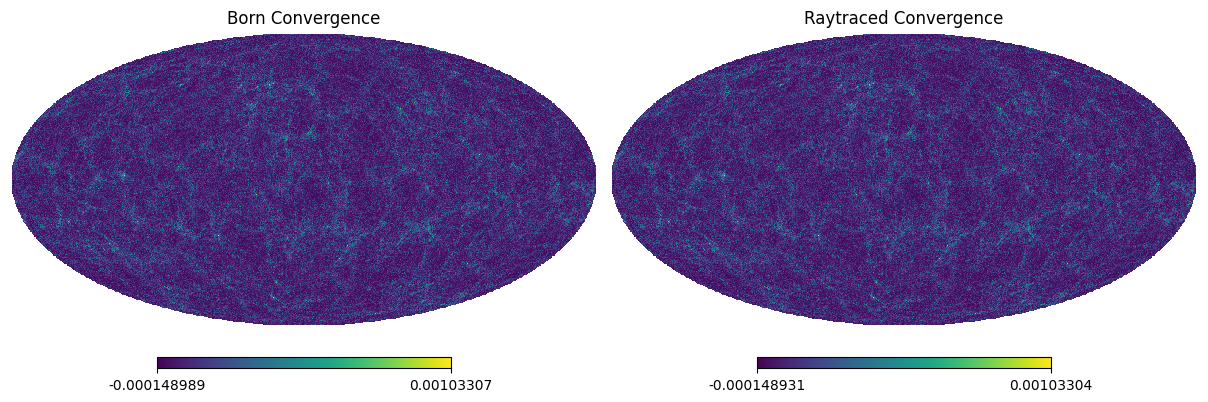

In [5]:
plt.figure(figsize=(12, 6))
hp.mollview(kappa_born, title="Born Convergence", sub=(1, 2, 1))
hp.mollview(kappa_raytraced, title="Raytraced Convergence", sub=(1, 2, 2))
plt.show()